# D&D Name generator

In [1]:
%matplotlib inline

import os
import sys
PROJECT_ROOT = os.path.dirname(os.getcwd())
sys.path.append(PROJECT_ROOT)

In [2]:
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

from data import DnDCharacterNameDataset
from train import RNNLayerTrainer
from generator import RNNLayerGenerator
from utils import read_log

## Dataset

Basic information about dataset

In [3]:
# Read the dataset
dataset = DnDCharacterNameDataset(os.path.join(PROJECT_ROOT, "data"))

# Print sample from dataset
train, target = dataset[4]
print("Name: {}".format(train['name']))
print("Gender: {}".format(train['gender']))  # List genders and races are just convinient way of storing information per
print("Race: {}".format(train['race']))      # letter for later transformation to indices
print("Target letters: {}".format(target))

Name: ['M', 'y', 'r', 'k', 'a']
Gender: ['female', 'female', 'female', 'female', 'female']
Race: ['dragonborn', 'dragonborn', 'dragonborn', 'dragonborn', 'dragonborn']
Target letters: ['y', 'r', 'k', 'a', '.']


**How many names per race?**

defaultdict(<class 'int'>, {'dragonborn': 154, 'dwarf': 218, 'elf': 202, 'halfling': 171, 'halforc': 124, 'human': 260, 'tiefling': 193})


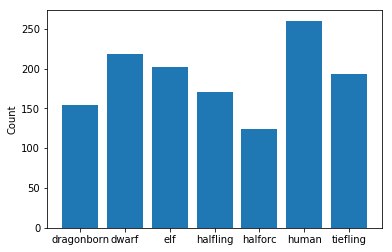

In [4]:
counter = defaultdict(int)

for train, target in dataset:
    race = train['race'][0]
    counter[race] += 1
print(counter)
    
x = np.arange(len(counter))
labels, y = zip(*counter.items())

plt.bar(x, y, tick_label=labels)
plt.ylabel("Count")
plt.show()

**How mana names with same first later?**

defaultdict(<class 'int'>, {'A': 117, 'K': 65, 'L': 53, 'M': 105, 'N': 57, 'O': 34, 'S': 99, 'T': 95, 'V': 59, 'Z': 21, 'B': 75, 'C': 50, 'D': 74, 'E': 55, 'F': 41, 'G': 58, 'H': 52, 'J': 22, 'P': 38, 'Q': 13, 'R': 65, 'U': 14, 'I': 30, 'X': 6, 'W': 17, 'Y': 7})


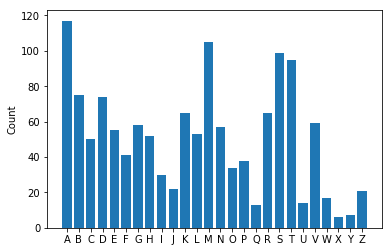

In [5]:
counter = defaultdict(int)

for train, target in dataset:
    first_letter = train['name'][0]
    counter[first_letter] += 1
    
x = np.arange(len(counter))
labels, y = zip(*sorted(counter.items()))
print(counter)

plt.bar(x, y, tick_label=labels)
plt.ylabel("Count")
plt.show()

## Training

Training configuration

In [6]:
epochs = 300
batch_size = 128
hidden_size = 128
learning_rate = 0.0001
device = "cuda"
logfile = "train_loss.log"
verbose = 0  # Removing outputs during training

Initialize trainer

In [7]:
trainer = RNNLayerTrainer(os.path.join(PROJECT_ROOT, "data"),
                          epochs=epochs,
                          batch_size=batch_size,
                          hidden_size=hidden_size,
                          lr=learning_rate,
                          device=device,
                          logfile=logfile,
                          verbose=verbose)

Run training loop for number of `epochs` and log losses. Models will be saved on 25 epoch intervals.

In [8]:
trainer.run_train_loop()

Started training!
Finished training!


Plot losses during training

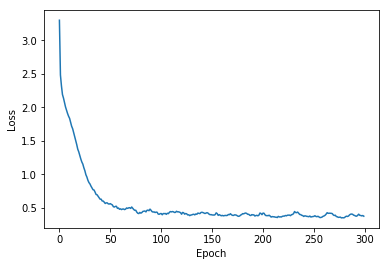

In [9]:
epochs, losses = read_log(os.path.join(PROJECT_ROOT, "train_loss.log"))

assert len(epochs) == len(losses), "Mismatch lengths. {} != {}".format(len(epochs), len(losses))

plt.plot(np.arange(len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Evaluation

* Examination of name quality over epochs
* Comparision between generated names and real examples

Create helper function that is going to find most similar name in dataset

In [4]:
import distance

def most_similar_name(name):
    """Find most similar name in dataset based on Levenshtein distance"""
    min_score = 1
    similar_name = None
    
    for train, _ in dataset:
        n = "".join(train['name'])
        score = distance.levenshtein(n, name, normalized=True)
        
        if score < min_score:
            min_score = score
            similar_name = n
    
    return similar_name, min_score

To validate how good generated names are, let us focus on only one specific letter/race/gender combination. This will make tracking changes across epochs easier. In this case, we'll sample an **Elven**, **Female** character name with start letter __B__. Since the model is trained on 300 epochs, let's take models at epochs **15**, **50**, **100**, **200**, **300**.

In [11]:
model_nums = [15, 50, 100, 200, 300]  # Take models from these epochs

for model_num in model_nums:
    model_path = os.path.join(PROJECT_ROOT, "models", "rnn_layer_epoch_{}.pt".format(model_num))
    generator = RNNLayerGenerator(model_path)
    
    letter, race, gender = "B", "elf", "female"
    name = generator.sample(letter, race, gender)
    similar_name, score = most_similar_name(name)
    
    print("Samples from model on epoch {}".format(model_num))
    print("Generated name: {}".format(name))
    print("Most similar name: {} with score {:.2f}\n".format(similar_name, score))

Samples from model on epoch 15
Generated name: Biyleth
Most similar name: Keyleth with score 0.29

Samples from model on epoch 50
Generated name: Bival
Most similar name: Mival with score 0.20

Samples from model on epoch 100
Generated name: Belen
Most similar name: Velene with score 0.33

Samples from model on epoch 200
Generated name: Bethrynna
Most similar name: Bethrynna with score 0.00

Samples from model on epoch 300
Generated name: Bethraloel
Most similar name: Bethrynna with score 0.50



**Comments**

To give a better perspective, these are the only Female Elf names that start with letter B:

Bethrynna   
Birel   
Baelitae   
Bethrynna   

From the previous example, you can see that the model is not trying to reproduce exact names but actually combine with others, for example, Bival (generated name) vs Mival (real name). Which doesn't sound so bad... Of course, there is some repetition with Bethrynna, but there is always a chance for that to happen.

Interestingly, it's hard to determine from these examples which of the models is actually the best here... I guess a deeper investigation on how the probabilities are distributed when sampling new letter might give more insight. Did we just gut lucky with randomness or some letters have much higher probability?